In [1]:
import tensorflow as tf
print("Tensor Flow version: {}".format(tf.__version__))

Tensor Flow version: 1.2.1


In [2]:
import numpy as np


In [4]:
matrix1 = tf.constant([[3., 3.]])
matrix2 = tf.constant([[2.],
                     [3.]])

In [10]:
print ("Shape of matrix: {} {}".format(matrix1.shape, matrix2.shape))

Shape of matrix: (1, 2) (2, 1)


In [11]:
product = tf.matmul(matrix1,matrix2)
print (product)

Tensor("MatMul:0", shape=(1, 1), dtype=float32)


In [13]:
with tf.Session() as sess:
    result = sess.run([product])
    print(result)

[array([[15.]], dtype=float32)]


In [14]:
sess = tf.InteractiveSession()

x = tf.Variable([1.0, 2.0])
a = tf.constant([3.0, 3.0])

x.initializer.run()

In [19]:
sub = tf.subtract(x,a)
print (sub.eval())

[-2. -1.]


In [20]:
sess.run(x.assign([4.0, 6.0]))

array([4., 6.], dtype=float32)

In [21]:
print (sub.eval())

[1. 3.]


In [23]:
sess.close()

In [26]:
print (a)

Tensor("Const_3:0", shape=(2,), dtype=float32)


## Keras TF example

In [30]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
import pandas as pd
import io

In [32]:
path = "./UW_deep_learning/data/"
filename = "auto-mpg.csv"

In [34]:
import os
fileread = os.path.join(path, filename)

In [39]:
df = pd.read_csv(fileread, na_values=['NA', '?'])
cars = df['name']


In [40]:
df.drop('name',1,inplace=True)
med = df['horsepower'].median()
df['horsepower'] = df['horsepower'].fillna(med)
# missing_median(df, 'horsepower')

In [41]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

In [42]:
x,y = to_xy(df,"mpg")

/home/krishna/miniconda3/envs/NNDL/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [72]:
model = Sequential()
model.add(Dense(25, input_dim = x.shape[1], activation='relu')) # Hidden 1
model.add(Dense(20, activation='relu')) #Hidden 2
model.add(Dense(15, activation='relu')) #Hidden 2
model.add(Dense(10, activation='relu')) #Hidden 2
# model.add(Dense(10, activation='relu')) #Hidden 2
model.add(Dense(1)) #Output 


model.compile(loss = 'mean_squared_error', optimizer='adam')
model.fit(x,y,verbose=0,epochs=100)

In [73]:
from sklearn import metrics
# Measure RMSE
pred = model.predict(x)


In [74]:

score = np.sqrt(metrics.mean_squared_error(pred,y))
print ("Final score (RMSE): {}".format(score))

Final score (RMSE): 3.5546157360076904


In [50]:
for i in range(10):
    print ("{}. care name: {}, predicted MPG: {}".format(i+1, cars[i], pred[i]))

1. care name: chevrolet chevelle malibu, predicted MPG: [17.756607]
2. care name: buick skylark 320, predicted MPG: [19.870102]
3. care name: plymouth satellite, predicted MPG: [21.20958]
4. care name: amc rebel sst, predicted MPG: [21.352493]
5. care name: ford torino, predicted MPG: [19.95671]
6. care name: ford galaxie 500, predicted MPG: [16.096695]
7. care name: chevrolet impala, predicted MPG: [18.711014]
8. care name: plymouth fury iii, predicted MPG: [18.740005]
9. care name: pontiac catalina, predicted MPG: [18.493088]
10. care name: amc ambassador dpl, predicted MPG: [21.232773]


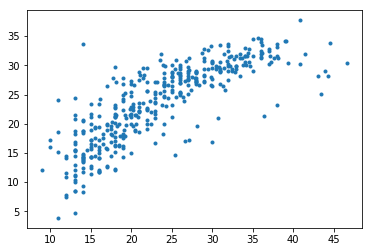

In [53]:
plt.plot(y,pred, ".");

In [54]:
print (x.shape)

(398, 7)


# Classification Neural Networks

In [76]:
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping

iris_file="iris.csv"
file_iris = os.path.join(path,iris_file)
df=pd.read_csv(file_iris,na_values=['NA','?'])

species = encode_text_index(df,"species")
x,y = to_xy(df,"species")


/home/krishna/miniconda3/envs/NNDL/lib/python3.6/site-packages/ipykernel_launcher.py:71: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [77]:
# Split into train/test
model = Sequential()
model.add(Dense(50, input_dim=x.shape[1], activation='relu')) # Hidden 1
model.add(Dense(25, activation='relu')) # Hidden 2
model.add(Dense(y.shape[1],activation='softmax')) # Output

model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(x,y,verbose=2,epochs=100)

Epoch 1/100
0s - loss: 1.1332
Epoch 2/100
0s - loss: 1.0507
Epoch 3/100
0s - loss: 0.9794
Epoch 4/100
0s - loss: 0.9179
Epoch 5/100
0s - loss: 0.8585
Epoch 6/100
0s - loss: 0.8025
Epoch 7/100
0s - loss: 0.7510
Epoch 8/100
0s - loss: 0.7038
Epoch 9/100
0s - loss: 0.6606
Epoch 10/100
0s - loss: 0.6260
Epoch 11/100
0s - loss: 0.5916
Epoch 12/100
0s - loss: 0.5604
Epoch 13/100
0s - loss: 0.5351
Epoch 14/100
0s - loss: 0.5062
Epoch 15/100
0s - loss: 0.4827
Epoch 16/100
0s - loss: 0.4639
Epoch 17/100
0s - loss: 0.4428
Epoch 18/100
0s - loss: 0.4258
Epoch 19/100
0s - loss: 0.4107
Epoch 20/100
0s - loss: 0.3940
Epoch 21/100
0s - loss: 0.3790
Epoch 22/100
0s - loss: 0.3649
Epoch 23/100
0s - loss: 0.3525
Epoch 24/100
0s - loss: 0.3409
Epoch 25/100
0s - loss: 0.3292
Epoch 26/100
0s - loss: 0.3196
Epoch 27/100
0s - loss: 0.3088
Epoch 28/100
0s - loss: 0.2981
Epoch 29/100
0s - loss: 0.2905
Epoch 30/100
0s - loss: 0.2794
Epoch 31/100
0s - loss: 0.2750
Epoch 32/100
0s - loss: 0.2656
Epoch 33/100
0s -

In [78]:
print (species)

['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


In [80]:
pred_c = model.predict(x)
print ("Shape: {}".format(pred_c
                          .shape))

Shape: (150, 3)


In [82]:
np.set_printoptions(suppress=True)
print (pred_c)

[[0.99792254 0.00207741 0.00000005]
 [0.9943869  0.00561289 0.0000002 ]
 [0.99657136 0.0034285  0.00000015]
 [0.99443644 0.00556323 0.00000031]
 [0.9982561  0.00174388 0.00000004]
 [0.9984293  0.00157066 0.00000002]
 [0.9971576  0.00284224 0.00000016]
 [0.9971126  0.00288733 0.00000008]
 [0.99274194 0.00725749 0.00000059]
 [0.9949401  0.00505971 0.00000017]
 [0.99845695 0.00154304 0.00000002]
 [0.99651676 0.00348308 0.00000013]
 [0.99455696 0.00544284 0.00000021]
 [0.99590164 0.004098   0.00000033]
 [0.9994344  0.00056559 0.        ]
 [0.99959725 0.00040276 0.        ]
 [0.9991693  0.00083069 0.00000001]
 [0.99791116 0.00208881 0.00000005]
 [0.99837846 0.00162155 0.00000001]
 [0.9986251  0.00137485 0.00000003]
 [0.99638116 0.00361878 0.00000005]
 [0.9982512  0.00174878 0.00000004]
 [0.99885374 0.00114621 0.00000005]
 [0.991691   0.00830865 0.00000036]
 [0.9922862  0.00771342 0.00000039]
 [0.9923646  0.00763519 0.00000025]
 [0.9959025  0.00409736 0.00000014]
 [0.99767923 0.00232075 0.00

In [83]:
print (y[:10])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [85]:
predicted_class = np.argmax(pred_c,axis=1)
expected_classes = np.argmax(y,axis=1)
print ("Predictions: {}".format(predicted_class))
print ("Expectations: {}".format(expected_classes))

Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
Expectations: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
